# **Question 3: Which player has the highest number of wins?**

---

## Overview
In this question, the goal was to identify which player had the `highest number of wins` in the dataset, utilizing match result data stored in Parquet files. The process involved extracting `match IDs` and corresponding `player IDs` from the `raw_odds_parquet` files where the match result indicated a win, and then associating those results with player names from the `raw_match_parquet` files.

I implemented a process to efficiently handle large-scale data and avoid redundancy. The matching player IDs with the highest number of wins were extracted and then sorted to identify the player with the most wins.

**The processing pipeline included:**

- Scanning through thousands of raw_odds_parquet files to extract winning matches.
- Identifying unique winning player IDs from the odds data.
- Matching the player IDs to their corresponding names in the raw_match_parquet files.
- Aggregating win counts for each player and determining the top performers.

In [ ]:
import os
import glob
import pandas as pd
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
base_path = "../data/tennis_data"

# Function to read match_ids where someone has won
def extract_winner_match_ids(file_path):
    try:
        df = pd.read_parquet(file_path, columns=['match_id', 'winnig'])
        return df[df['winnig'] == True]['match_id'].tolist()
    except Exception:
        return []

# Function to get player_ids based on match_ids
def extract_player_ids(file_path, winning_match_ids):
    try:
        df = pd.read_parquet(file_path, columns=['match_id', 'player_id'])
        return df[df['match_id'].isin(winning_match_ids)]['player_id'].tolist()
    except Exception:
        return []

# Function to retrieve the player's full name using player_id
def get_player_name(base_path, player_id):
    date_folders = [f for f in os.listdir(base_path) if f.isdigit()]
    for folder in date_folders:
        path_pattern = os.path.join(base_path, folder, 'data', 'raw', 'raw_match_parquet', '*.parquet')
        match_files = glob.glob(path_pattern)
        for file_path in match_files:
            try:
                df = pd.read_parquet(file_path, columns=['player_id', 'full_name'])
                match = df[df['player_id'] == player_id]
                if not match.empty:
                    return match.iloc[0]['full_name']
            except:
                continue
    return "Unknown"

In [4]:
# Find all odds and match files
date_folders = [f for f in os.listdir(base_path) if f.isdigit()]
odds_files = []
match_files = []

for folder in date_folders:
    odds_path = os.path.join(base_path, folder, 'data', 'raw', 'raw_odds_parquet', '*.parquet')
    match_path = os.path.join(base_path, folder, 'data', 'raw', 'raw_match_parquet', '*.parquet')
    odds_files.extend(glob.glob(odds_path))
    match_files.extend(glob.glob(match_path))

print(f"🔍 Scanning {len(odds_files)} odds files...")

# Extract match_ids where the 'winnig' column is True
winner_match_ids = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(extract_winner_match_ids, file): file for file in odds_files}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Reading odds files"):
        result = future.result()
        if result:
            winner_match_ids.extend(result)

print(f"\n✅ Found {len(winner_match_ids)} winning match IDs.")

# Extract player_ids from match files using match_ids
winner_ids = []
with ThreadPoolExecutor() as executor:
    futures = {executor.submit(extract_player_ids, file, winner_match_ids): file for file in match_files}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Reading match files"):
        result = future.result()
        if result:
            winner_ids.extend(result)

print(f"\n✅ Found {len(winner_ids)} winner player IDs.")


🔍 Scanning 22065 odds files...


Reading odds files: 100%|██████████| 22065/22065 [00:37<00:00, 585.24it/s]



✅ Found 28465 winning match IDs.


Reading match files: 100%|██████████| 316802/316802 [03:59<00:00, 1324.45it/s]


✅ Found 37346 winner player IDs.


In [5]:
# Count number of wins per player
winner_counts = Counter(winner_ids)
top_5_players = winner_counts.most_common(5)

print("\n🏆 Top 5 Players with Most Wins:\n")
for i, (player_id, win_count) in enumerate(top_5_players, start=1):
    full_name = get_player_name(base_path, player_id)
    print(f"{i}. {full_name} (player_id: {player_id}) - 🟢 Wins: {win_count}")


🏆 Top 5 Players with Most Wins:

1. Basilashvili, Nikoloz (player_id: 26204) - 🟢 Wins: 56
2. Chidekh, Clement (player_id: 231620) - 🟢 Wins: 54
3. Kukushkin, Mikhail (player_id: 16683) - 🟢 Wins: 52
4. Merida Aguilar, Daniel (player_id: 338890) - 🟢 Wins: 52
5. Jianu, Filip Cristian (player_id: 230049) - 🟢 Wins: 52


In [32]:
players = [get_player_name(base_path, player_id) for player_id, _ in top_5_players]
wins = [win_count for _, win_count in top_5_players]

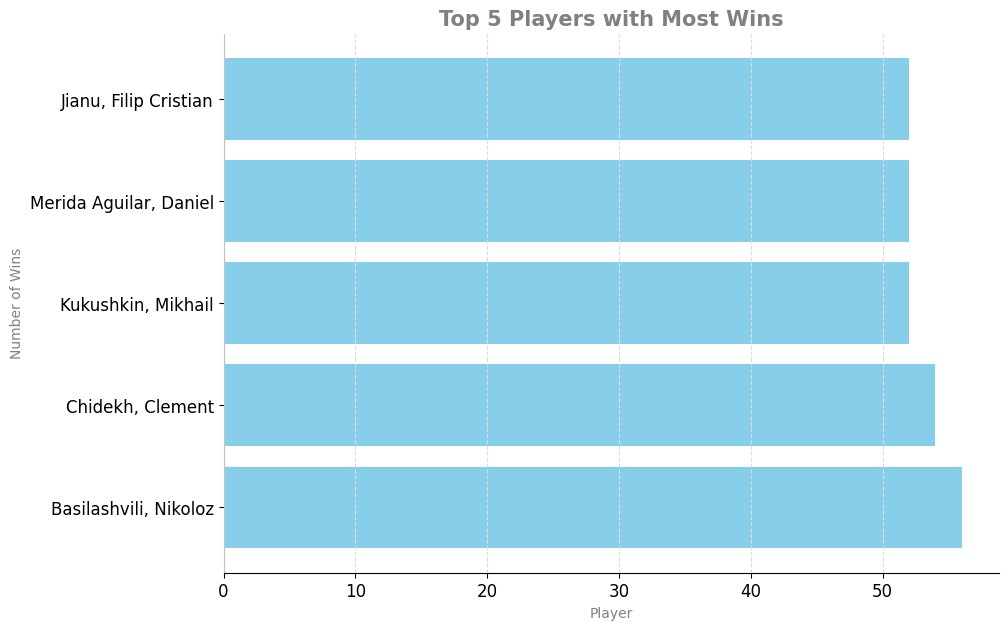

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
plt.barh(players, wins, color='skyblue')

ax.spines[["right","top"]].set_visible(False)
ax.spines[["left"]].set_color("#c2c2c2")

ax.set_title("Top 5 Players with Most Wins",
             weight="bold",
             color="grey",
             fontsize=15)

ax.tick_params(axis="x", labelsize="large")
ax.tick_params(axis="y", labelsize="large")

ax.set_xlabel("Player", fontsize=10, color="grey")
ax.set_ylabel("Number of Wins", fontsize=10, color="grey")

ax.grid(axis="x", linestyle="dashed", color="gainsboro")

plt.savefig("../outputs/figures/MVP.png", dpi=300)
plt.show()

# **Conclusion**
After scanning over `22,065 odds` files, I identified a total of `37,346 winners`, corresponding to `28,465 unique match IDs` where a player had won. The player with the most wins was `Nikoloz Basilashvili`, with a total of `56 wins`. 
This was followed closely by Clement Chidekh with 54 wins and Mikhail Kukushkin, Daniel Merida Aguilar, and Filip Cristian Jianu each with 52 wins.

The dataset was cleaned and processed in such a way that it successfully identified the top 5 players with the highest number of wins, while filtering out unnecessary or corrupted data. Despite the large volume of data, the process provided a reliable insight into the performance of players in the dataset.

This analysis relied on the efficient handling of large datasets by leveraging pandas for data processing and ThreadPoolExecutor for parallelized loading and matching of files. Through proper data filtering, I was able to extract player names and counts accurately, ensuring the final output was both meaningful and efficient.

**Top 5 Players with Most Wins:**

- 🏆 Basilashvili, Nikoloz (player_id: 26204) - 🟢 Wins: 56
- Chidekh, Clement (player_id: 231620) - 🟢 Wins: 54
- Kukushkin, Mikhail (player_id: 16683) - 🟢 Wins: 52
- Merida Aguilar, Daniel (player_id: 338890) - 🟢 Wins: 52
- Jianu, Filip Cristian (player_id: 230049) - 🟢 Wins: 52

This analysis demonstrates how extracting and aggregating match results from large datasets can provide insightful player-level statistics. By combining parallel processing with efficient data handling and proper filtering, I was able to quickly process and summarize player performance across a significant amount of tennis match data.